<a href="https://colab.research.google.com/github/elijkon/Speech-Emotion-Classification-with-CNNs/blob/main/DL_miniHackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Elijah Konkle, Kritan, and Mayur
Deep learning minihackathon

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

1) Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

2) Vocal channel (01 = speech, 02 = song).

3) Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

4) Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

5) Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

6) Repetition (01 = 1st repetition, 02 = 2nd repetition).

7) Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 03-01-06-01-02-01-12.wav

Audio-only (03)
Speech (01)
Fearful (06)
Normal intensity (01)
Statement "dogs" (02)
1st Repetition (01)
12th Actor (12)
Female, as the actor ID number is even.
'''

'\nElijah Konkle, Kritan, and Mayur\nDeep learning minihackathon\n\nEach of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:\n\nFilename identifiers\n\n1) Modality (01 = full-AV, 02 = video-only, 03 = audio-only).\n\n2) Vocal channel (01 = speech, 02 = song).\n\n3) Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).\n\n4) Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the \'neutral\' emotion.\n\n5) Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").\n\n6) Repetition (01 = 1st repetition, 02 = 2nd repetition).\n\n7) Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).\n\nFilename example: 03-01-06-01-02-01-12.wav\n\nAudio-only (03)\nSpeech (01)\nFearful (06)\nNormal intensity (01)\nStatement "dog

In [ ]:
# 1. Install deps (if not already installed)
!pip install datasets torch torchvision

# 2. Import libraries
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import wandb
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time

In [ ]:

from datasets import load_dataset
from google.colab import userdata
HF_Token = userdata.get('HF_TOKEN')
from huggingface_hub import login
if HF_Token:
  login(token=HF_Token)
  print("Successfully logged in to Hugging Face!")
else:
  print("HF_TOKEN secret not found. Please add it to Colab Secrets.")
dataset = load_dataset("elijkon/DL_Spectrograms")

Successfully logged in to Hugging Face!


Resolving data files:   0%|          | 0/1004 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/218 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/218 [00:00<?, ?it/s]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
if device==torch.device('cpu'): print("You should probably restart this with a GPU. It will be slow otherwise.")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1004
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 218
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 218
    })
})

In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['test']
validation_dataset = dataset['validation']

In [ ]:
print(train_dataset)
print(train_dataset.column_names)  # shows column names
print(train_dataset[0])             # shows first sample

Dataset({
    features: ['image', 'label'],
    num_rows: 1004
})
['image', 'label']
{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=193x192 at 0x7D0959824E00>, 'label': 0}


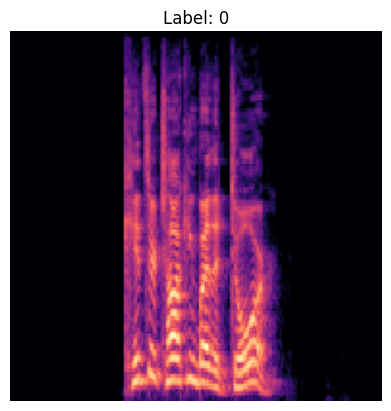

In [ ]:
sample = train_dataset[30]
# Load image (column name might be 'image' or something else)
img = sample['image']   # already a PIL Image object if stored as such
label = sample['label']

# Display
plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


In [ ]:
num_channels = 1 if img.mode == "L" else 3
img_height, img_width = img.size[::-1]  # PIL gives (width, height)

dataset_info = {
    "num_channels": 1,
    "img_height": img_height,
    "img_width": img_width,
    "num_classes": len(set(dataset["train"]["label"])),  # unique labels
    "class_names": list(set(dataset["train"]["label"]))
}

print(dataset_info)

{'num_channels': 1, 'img_height': 192, 'img_width': 193, 'num_classes': 8, 'class_names': [0, 1, 2, 3, 4, 5, 6, 7]}


Batch shape: torch.Size([64, 1, 128, 128])
Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


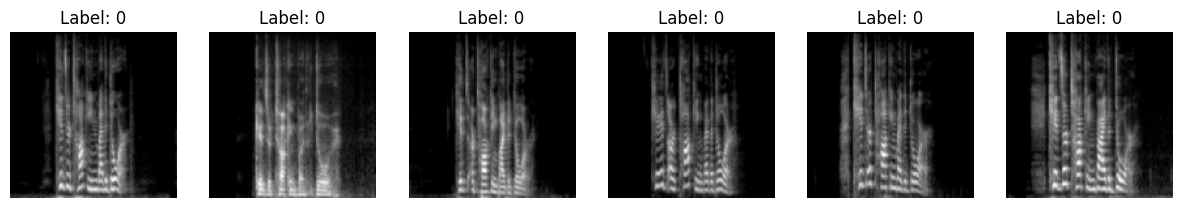

In [ ]:

# 4. Define transforms for CNN
transform = transforms.Compose([
    transforms.Resize((128, 128)),      # Resize to fixed size
    transforms.Grayscale(num_output_channels=1),  # spectrograms usually grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])   # normalize [-1,1]
])

# 5. Wrap HF dataset into PyTorch Dataset
class SpectrogramDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        img = sample["image"]
        label = sample["label"]

        # If HF image is stored as file path, open it
        if isinstance(img, str):
            img = Image.open(img)

        if self.transform:
            img = self.transform(img)

        return img, label

# 6. Train / Test splits
train_dataset1 = SpectrogramDataset(train_dataset, transform=transform)
test_dataset1 = SpectrogramDataset(test_dataset, transform=transform)
validation_dataset1 = SpectrogramDataset(validation_dataset, transform=transform)

# 7. Dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset1, batch_size=batch_size, shuffle = False)
# 8. View a few sample images
imgs, labels = next(iter(test_loader))

print(f"Batch shape: {imgs.shape}")   # [B, C, H, W]
print(f"Labels: {labels[:10]}")

# Un-normalize for display
def show_images(imgs, labels, n=6):
    imgs = imgs[:n].clone()
    labels = labels[:n]
    imgs = imgs * 0.5 + 0.5  # unnormalize from [-1,1] to [0,1]

    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(imgs[i][0], cmap="gray")
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")
    plt.show()

show_images(imgs, labels)


In [ ]:
def train_model(model, train_loader, test_loader, epochs=50, lr=0.001):
    # Initialize wandb
    model_name = type(model).__name__
    wandb.init(project=f"convnet_spectrogram", name=f"{model_name},relu", reinit=True)
    wandb.config.update({
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": lr,
        "model": model_name,
        "optimizer": "Adam"
    })

    # Loss function:
    # Note: targets are just class indices (0-9), not one-hot vectors
    # nn.CrossEntropyLoss handles one-hot encoding internally for efficiency
    criterion = nn.CrossEntropyLoss()   # used for categorical variables, expects raw "logits"

    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Use tqdm for progress bar
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')

        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct_train += pred.eq(target.view_as(pred)).sum().item()
            total_train += target.size(0)

            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct_train/total_train:.2f}%'
            })

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        train_acc = 100. * correct_train / total_train

        # Evaluation phase
        model.eval()
        test_loss_sum = 0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss_sum += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct_test += pred.eq(target.view_as(pred)).sum().item()
                total_test += target.size(0)

        test_loss = test_loss_sum / len(test_loader)
        test_acc = 100.0 * correct_test / total_test

        # Store metrics
        train_losses.append(epoch_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Log to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": epoch_loss,
            "test_loss": test_loss,
            "train_accuracy": train_acc,
            "test_accuracy": test_acc
        })

        print(f'Epoch {epoch+1}: Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f} Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

    wandb.finish()

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'final_test_acc': test_acc
    }

In [ ]:
class CNN(nn.Module):
    def __init__(self, dataset_info, base_channels=32, channel_mult=2, n_conv_layers=4):
        super(CNN, self).__init__()

        # Build conv layers dynamically
        self.conv_layers = nn.ModuleList()
        in_channels = dataset_info['num_channels']
        for i in range(n_conv_layers):
            out_channels = base_channels * (channel_mult ** i)
            self.conv_layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1))
            in_channels = out_channels

        self.activation = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1) # put near end: yields one value per channel

        # Final channels after all conv layers
        final_channels = base_channels * (channel_mult ** (n_conv_layers - 1))
        self.fc = nn.Linear(final_channels, dataset_info['num_classes'])

    def forward(self, x):
        for conv_layer in self.conv_layers:
            x = self.activation(conv_layer(x))
            x = self.dropout1(x)
        x = self.global_avg_pool(x)  # one value per channel
        return self.fc(  x.flatten(start_dim=1) )  # flatten and run through linear layer



cnn_model = CNN(dataset_info).to(device)
print(f"CNN Model Parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")

# quick test to make sure the forward() runs w/o errors:
rnd_batch = torch.randn([128,dataset_info['num_channels'], dataset_info['img_height'], dataset_info['img_width']]).to(device)
result = cnn_model(rnd_batch)
del rnd_batch

CNN Model Parameters: 389,896


In [ ]:
print("\nTraining CNN Model...")
start_time = time.time()
cnn_results = train_model(cnn_model, train_loader, validation_loader, epochs=50)
cnn_training_time = time.time() - start_time
print(f"CNN Training completed in {cnn_training_time:.2f} seconds")


Training CNN Model...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: elijah-konkle (elijah-konkle-belmont-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/50: 100%|██████████| 16/16 [00:03<00:00,  4.87it/s, Loss=2.0776, Acc=13.15%]


Epoch 1: Train Loss: 2.0723, Test Loss: 2.0533 Train Acc: 13.15%, Test Acc: 12.84%


Epoch 2/50: 100%|██████████| 16/16 [00:02<00:00,  5.90it/s, Loss=2.1114, Acc=12.65%]


Epoch 2: Train Loss: 2.0642, Test Loss: 2.0587 Train Acc: 12.65%, Test Acc: 12.39%


Epoch 3/50: 100%|██████████| 16/16 [00:02<00:00,  5.93it/s, Loss=2.0658, Acc=11.55%]


Epoch 3: Train Loss: 2.0636, Test Loss: 2.0531 Train Acc: 11.55%, Test Acc: 13.30%


Epoch 4/50: 100%|██████████| 16/16 [00:02<00:00,  5.95it/s, Loss=2.0644, Acc=12.15%]


Epoch 4: Train Loss: 2.0633, Test Loss: 2.0534 Train Acc: 12.15%, Test Acc: 13.30%


Epoch 5/50: 100%|██████████| 16/16 [00:02<00:00,  5.80it/s, Loss=2.0919, Acc=13.35%]


Epoch 5: Train Loss: 2.0670, Test Loss: 2.0586 Train Acc: 13.35%, Test Acc: 13.30%


Epoch 6/50: 100%|██████████| 16/16 [00:02<00:00,  5.83it/s, Loss=2.0399, Acc=14.14%]


Epoch 6: Train Loss: 2.0588, Test Loss: 2.0451 Train Acc: 14.14%, Test Acc: 14.22%


Epoch 7/50: 100%|██████████| 16/16 [00:02<00:00,  5.93it/s, Loss=2.0466, Acc=19.02%]


Epoch 7: Train Loss: 2.0356, Test Loss: 2.0116 Train Acc: 19.02%, Test Acc: 20.64%


Epoch 8/50: 100%|██████████| 16/16 [00:02<00:00,  5.93it/s, Loss=1.8117, Acc=20.92%]


Epoch 8: Train Loss: 1.9761, Test Loss: 1.9485 Train Acc: 20.92%, Test Acc: 22.94%


Epoch 9/50: 100%|██████████| 16/16 [00:02<00:00,  5.89it/s, Loss=1.8828, Acc=24.50%]


Epoch 9: Train Loss: 1.9040, Test Loss: 1.9305 Train Acc: 24.50%, Test Acc: 29.82%


Epoch 10/50: 100%|██████████| 16/16 [00:02<00:00,  5.83it/s, Loss=1.8546, Acc=27.99%]


Epoch 10: Train Loss: 1.8602, Test Loss: 1.8007 Train Acc: 27.99%, Test Acc: 33.94%


Epoch 11/50: 100%|██████████| 16/16 [00:02<00:00,  5.89it/s, Loss=1.6849, Acc=31.67%]


Epoch 11: Train Loss: 1.7439, Test Loss: 1.7234 Train Acc: 31.67%, Test Acc: 35.78%


Epoch 12/50: 100%|██████████| 16/16 [00:02<00:00,  5.91it/s, Loss=1.5722, Acc=34.96%]


Epoch 12: Train Loss: 1.6868, Test Loss: 1.7072 Train Acc: 34.96%, Test Acc: 32.57%


Epoch 13/50: 100%|██████████| 16/16 [00:02<00:00,  5.86it/s, Loss=1.6676, Acc=35.16%]


Epoch 13: Train Loss: 1.6624, Test Loss: 1.6817 Train Acc: 35.16%, Test Acc: 35.78%


Epoch 14/50: 100%|██████████| 16/16 [00:02<00:00,  5.95it/s, Loss=1.5238, Acc=36.85%]


Epoch 14: Train Loss: 1.6072, Test Loss: 1.5596 Train Acc: 36.85%, Test Acc: 40.37%


Epoch 15/50: 100%|██████████| 16/16 [00:02<00:00,  5.92it/s, Loss=1.6459, Acc=39.34%]


Epoch 15: Train Loss: 1.5702, Test Loss: 1.6577 Train Acc: 39.34%, Test Acc: 37.61%


Epoch 16/50: 100%|██████████| 16/16 [00:02<00:00,  5.90it/s, Loss=1.6265, Acc=36.35%]


Epoch 16: Train Loss: 1.5797, Test Loss: 1.6210 Train Acc: 36.35%, Test Acc: 40.83%


Epoch 17/50: 100%|██████████| 16/16 [00:02<00:00,  5.83it/s, Loss=1.5945, Acc=42.73%]


Epoch 17: Train Loss: 1.5230, Test Loss: 1.5187 Train Acc: 42.73%, Test Acc: 43.12%


Epoch 18/50: 100%|██████████| 16/16 [00:02<00:00,  5.87it/s, Loss=1.4274, Acc=43.92%]


Epoch 18: Train Loss: 1.4778, Test Loss: 1.4786 Train Acc: 43.92%, Test Acc: 44.50%


Epoch 19/50: 100%|██████████| 16/16 [00:02<00:00,  5.83it/s, Loss=1.2376, Acc=44.62%]


Epoch 19: Train Loss: 1.4366, Test Loss: 1.4934 Train Acc: 44.62%, Test Acc: 44.95%


Epoch 20/50: 100%|██████████| 16/16 [00:02<00:00,  5.87it/s, Loss=1.5377, Acc=44.52%]


Epoch 20: Train Loss: 1.4237, Test Loss: 1.5186 Train Acc: 44.52%, Test Acc: 48.62%


Epoch 21/50: 100%|██████████| 16/16 [00:02<00:00,  5.85it/s, Loss=1.4355, Acc=48.90%]


Epoch 21: Train Loss: 1.3829, Test Loss: 1.5784 Train Acc: 48.90%, Test Acc: 46.33%


Epoch 22/50: 100%|██████████| 16/16 [00:02<00:00,  5.94it/s, Loss=1.3226, Acc=46.41%]


Epoch 22: Train Loss: 1.3536, Test Loss: 1.3998 Train Acc: 46.41%, Test Acc: 46.33%


Epoch 23/50: 100%|██████████| 16/16 [00:02<00:00,  5.93it/s, Loss=1.3449, Acc=50.10%]


Epoch 23: Train Loss: 1.3213, Test Loss: 1.3656 Train Acc: 50.10%, Test Acc: 51.38%


Epoch 24/50: 100%|██████████| 16/16 [00:02<00:00,  5.78it/s, Loss=1.2466, Acc=53.09%]


Epoch 24: Train Loss: 1.2774, Test Loss: 1.3033 Train Acc: 53.09%, Test Acc: 51.38%


Epoch 25/50: 100%|██████████| 16/16 [00:02<00:00,  5.91it/s, Loss=1.3101, Acc=52.29%]


Epoch 25: Train Loss: 1.2598, Test Loss: 1.2796 Train Acc: 52.29%, Test Acc: 52.75%


Epoch 26/50: 100%|██████████| 16/16 [00:02<00:00,  5.92it/s, Loss=1.1486, Acc=54.58%]


Epoch 26: Train Loss: 1.2432, Test Loss: 1.4386 Train Acc: 54.58%, Test Acc: 43.58%


Epoch 27/50: 100%|██████████| 16/16 [00:02<00:00,  5.86it/s, Loss=0.9425, Acc=51.49%]


Epoch 27: Train Loss: 1.2462, Test Loss: 1.2776 Train Acc: 51.49%, Test Acc: 50.46%


Epoch 28/50: 100%|██████████| 16/16 [00:02<00:00,  5.79it/s, Loss=1.2433, Acc=55.68%]


Epoch 28: Train Loss: 1.1604, Test Loss: 1.4202 Train Acc: 55.68%, Test Acc: 49.54%


Epoch 29/50: 100%|██████████| 16/16 [00:02<00:00,  5.90it/s, Loss=1.2387, Acc=55.78%]


Epoch 29: Train Loss: 1.1640, Test Loss: 1.3192 Train Acc: 55.78%, Test Acc: 54.59%


Epoch 30/50: 100%|██████████| 16/16 [00:02<00:00,  5.87it/s, Loss=1.2127, Acc=59.66%]


Epoch 30: Train Loss: 1.0962, Test Loss: 1.2667 Train Acc: 59.66%, Test Acc: 52.29%


Epoch 31/50: 100%|██████████| 16/16 [00:02<00:00,  5.83it/s, Loss=1.3254, Acc=58.37%]


Epoch 31: Train Loss: 1.1182, Test Loss: 1.2399 Train Acc: 58.37%, Test Acc: 54.59%


Epoch 32/50: 100%|██████████| 16/16 [00:02<00:00,  5.93it/s, Loss=0.9234, Acc=60.86%]


Epoch 32: Train Loss: 1.0618, Test Loss: 1.2640 Train Acc: 60.86%, Test Acc: 51.38%


Epoch 33/50: 100%|██████████| 16/16 [00:02<00:00,  5.90it/s, Loss=0.9311, Acc=61.65%]


Epoch 33: Train Loss: 1.0222, Test Loss: 1.3153 Train Acc: 61.65%, Test Acc: 52.29%


Epoch 34/50: 100%|██████████| 16/16 [00:02<00:00,  5.93it/s, Loss=0.9095, Acc=62.15%]


Epoch 34: Train Loss: 1.0148, Test Loss: 1.3456 Train Acc: 62.15%, Test Acc: 51.38%


Epoch 35/50: 100%|██████████| 16/16 [00:02<00:00,  5.86it/s, Loss=1.1757, Acc=65.24%]


Epoch 35: Train Loss: 0.9677, Test Loss: 1.2498 Train Acc: 65.24%, Test Acc: 51.83%


Epoch 36/50: 100%|██████████| 16/16 [00:02<00:00,  5.86it/s, Loss=0.8907, Acc=65.74%]


Epoch 36: Train Loss: 0.9292, Test Loss: 1.2594 Train Acc: 65.74%, Test Acc: 53.67%


Epoch 37/50: 100%|██████████| 16/16 [00:02<00:00,  5.86it/s, Loss=0.9959, Acc=67.13%]


Epoch 37: Train Loss: 0.9141, Test Loss: 1.3723 Train Acc: 67.13%, Test Acc: 52.29%


Epoch 38/50: 100%|██████████| 16/16 [00:02<00:00,  5.83it/s, Loss=0.8411, Acc=67.23%]


Epoch 38: Train Loss: 0.8942, Test Loss: 1.2315 Train Acc: 67.23%, Test Acc: 55.50%


Epoch 39/50: 100%|██████████| 16/16 [00:02<00:00,  5.88it/s, Loss=1.2026, Acc=67.13%]


Epoch 39: Train Loss: 0.9132, Test Loss: 1.2815 Train Acc: 67.13%, Test Acc: 53.21%


Epoch 40/50: 100%|██████████| 16/16 [00:02<00:00,  5.94it/s, Loss=0.8007, Acc=69.02%]


Epoch 40: Train Loss: 0.8408, Test Loss: 1.2201 Train Acc: 69.02%, Test Acc: 56.88%


Epoch 41/50: 100%|██████████| 16/16 [00:02<00:00,  5.89it/s, Loss=0.8386, Acc=71.12%]


Epoch 41: Train Loss: 0.8141, Test Loss: 1.3367 Train Acc: 71.12%, Test Acc: 55.50%


Epoch 42/50: 100%|██████████| 16/16 [00:02<00:00,  5.83it/s, Loss=0.6859, Acc=71.12%]


Epoch 42: Train Loss: 0.7712, Test Loss: 1.2927 Train Acc: 71.12%, Test Acc: 55.05%


Epoch 43/50: 100%|██████████| 16/16 [00:02<00:00,  5.90it/s, Loss=0.8356, Acc=69.82%]


Epoch 43: Train Loss: 0.8047, Test Loss: 1.3091 Train Acc: 69.82%, Test Acc: 54.13%


Epoch 44/50: 100%|██████████| 16/16 [00:02<00:00,  5.73it/s, Loss=0.6723, Acc=73.11%]


Epoch 44: Train Loss: 0.7513, Test Loss: 1.3569 Train Acc: 73.11%, Test Acc: 49.08%


Epoch 45/50: 100%|██████████| 16/16 [00:02<00:00,  5.89it/s, Loss=0.9828, Acc=74.10%]


Epoch 45: Train Loss: 0.7293, Test Loss: 1.3265 Train Acc: 74.10%, Test Acc: 54.59%


Epoch 46/50: 100%|██████████| 16/16 [00:02<00:00,  5.74it/s, Loss=0.7783, Acc=71.22%]


Epoch 46: Train Loss: 0.7735, Test Loss: 1.1289 Train Acc: 71.22%, Test Acc: 57.34%


Epoch 47/50: 100%|██████████| 16/16 [00:02<00:00,  5.90it/s, Loss=0.5985, Acc=74.30%]


Epoch 47: Train Loss: 0.6888, Test Loss: 1.2198 Train Acc: 74.30%, Test Acc: 57.34%


Epoch 48/50: 100%|██████████| 16/16 [00:02<00:00,  5.95it/s, Loss=0.4897, Acc=77.39%]


Epoch 48: Train Loss: 0.6215, Test Loss: 1.4471 Train Acc: 77.39%, Test Acc: 54.13%


Epoch 49/50: 100%|██████████| 16/16 [00:02<00:00,  5.86it/s, Loss=0.6948, Acc=78.49%]


Epoch 49: Train Loss: 0.6250, Test Loss: 1.1954 Train Acc: 78.49%, Test Acc: 54.59%


Epoch 50/50: 100%|██████████| 16/16 [00:02<00:00,  5.89it/s, Loss=0.5071, Acc=76.89%]


Epoch 50: Train Loss: 0.6127, Test Loss: 1.3795 Train Acc: 76.89%, Test Acc: 52.29%


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁▁▁▁▁▃▄▄▅▄▅▅▅▆▆▆▆▇▇▇▇▇█▇█▇▇▇▇▇▇███▇███▇▇
test_loss,█████▇▇▆▅▅▄▅▅▄▄▄▄▃▃▂▃▂▃▂▂▂▂▃▂▃▂▂▃▂▂▂▁▂▃▃
train_accuracy,▁▁▁▁▁▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇█▇███
train_loss,███████▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁
epoch,50
test_accuracy,52.29358
test_loss,1.37951
train_accuracy,76.89243
train_loss,0.61269


CNN Training completed in 259.13 seconds


In [ ]:
#
#THIS IS THE FINAL MODEL USING THE VALIDATION SET WITH NO DROPOUTS AND DOES NOT CALC GRADIENTS.
#
# --- Final Evaluation on Test Set ---

# Ensure the model is on the correct device and in evaluation mode
cnn_model.to(device)
cnn_model.eval()

# We need the same loss function as before
criterion = nn.CrossEntropyLoss()

# Initialize variables to track performance
test_loss = 0.0
correct_test = 0
total_test = 0

# Disable gradient calculations for efficiency
with torch.no_grad():
    # Loop through the test data
    for data, target in test_loader:
        # Move data to the device (GPU/CPU)
        data, target = data.to(device), target.to(device)

        # Get model predictions
        output = cnn_model(data)

        # Calculate the loss for this batch
        loss = criterion(output, target)
        test_loss += loss.item()

        # Get the class with the highest probability
        pred = output.argmax(dim=1, keepdim=True)

        # Count correct predictions
        correct_test += pred.eq(target.view_as(pred)).sum().item()
        total_test += target.size(0)

# Calculate final accuracy and loss
final_accuracy = 100. * correct_test / total_test
avg_loss = test_loss / len(test_loader)

print(f"\n--- Final Test Results ---")
print(f"Average Loss: {avg_loss:.4f}")
print(f"Accuracy: {correct_test}/{total_test} ({final_accuracy:.2f}%)")


--- Final Test Results ---
Average Loss: 1.4275
Accuracy: 119/218 (54.59%)
